In [2]:
#library import
import re
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras import utils
from keras import backend as K
from keras.models import Sequential, Model
from keras import models, layers, optimizers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Add, concatenate, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers.convolutional import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


Using TensorFlow backend.


In [3]:
def set_seed(seed):
    np.random.seed(seed)
    tf.set_random_seed(seed)
    print('[*]Set seed: {}'.format(seed))

In [4]:
'''
model 평가함수 작성
recall + precision 을 이용하여 f1 score 계산
model Callback 함수에서 사용
'''
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
 

In [5]:
'''
데이터 수, batch_size를 이용하여 step 계산
'''
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [6]:
'''
Epoch 종료 시 마다 수행
'''
def get_callback(model_path, lr, monitor, patient=10, warmup_epoch=5, min_lr=0.00001):
    
    monitor = 'val_acc' if monitor is 'val_acc' else 'val_f1_m'
    direction = 'max' if monitor in ['val_f1_m', 'val_acc'] else 'min'
    
    callbacks = [
        #조기 종료
        EarlyStopping(monitor=monitor,
                      patience=patient,
                      mode=direction,
                      verbose=1),
        #모델 저장
        ModelCheckpoint(filepath=model_path,
                        monitor=monitor,
                        verbose=1,
                        save_best_only=True,
                        mode=direction),
        #lr decay
        ReduceLROnPlateau(monitor = monitor,
                          factor = 0.5,
                          patience = patient / 4,
                          min_lr=min_lr,
                          verbose=1,
                          mode=direction,
                          warmup_epoch=warmup_epoch)
    ]
    return callbacks

In [7]:
#read file and return binary data
'''
read file -> binary values
'''
def getBinaryData(filename):
	binaryValues = []
	file = open(filename, "rb")
	data = file.read(1)
	while data != b"":
		try:
			binaryValues.append(ord(data))

		except TypeError:
			pass

		data = file.read(1)

	return binaryValues

In [8]:
#byte frequency
def balanceByte(filename, table):
    
    fn = filename.split("/")[-1]
    zero = float(table[0])/4096.0
    low = float(sum(table[1:31]))/4096.0
    ascii = float(sum(table[32:127]))/4096.0
    high = float(sum(table[128:254]))/4096.0
    ff = float(table[255])/4096.0
    return [zero, low, ascii, high, ff]

def get_frequency(filename):
    table = [0] * 256
    data = open(filename, 'rb')
    buff = data.read(2 ** 20)
    while buff:
        for c in buff:
            table[c] += 1
        buff = data.read(2 ** 20)
    data.close()
    table.extend(balanceByte(filename, table))
    
    return table

In [9]:
def make_path(path_dir):
    if not os.path.exists(path_dir):
        os.makedirs(path_dir)
        print('[*]Make dir: {}'.format(path_dir))

In [10]:
def make_data(raw_file, data_dir):
    if os.path.exists(data_dir):
        return
    os.makedirs(data_dir)
    print('[*]Make dir: {}'.format(data_dir))
    chunk_size = 4096
    idx = 0
    print('[*]Make bin file')
    with open(raw_file, "rb") as f:
        chunk = f.read(chunk_size)
        while chunk:
            with open(os.path.join(data_dir, str(idx)), "wb") as chunk_file:
                chunk_file.write(chunk)
            idx += 1
            chunk = f.read(chunk_size)
            print('>>{0:<10}'.format(idx), end='\r', flush=True)

In [11]:
def get_byte_cols():
    byte_cols = []
    for col in range(0, 256):
        byte_cols.append(col)
    for col in ['0x00', 'low', 'ascii', 'high','0xff']:
        byte_cols.append(col)
    return byte_cols

In [12]:
def add_frequency(df, data_dir, byte_cols):
    #add frequency col
    for col in byte_cols:
        df[col] = None
    rs = []
    for idx in range(0, len(df)):
        table = get_frequency(os.path.join(data_dir, df.iloc[idx]['file']))
        series = dict(zip(byte_cols, table))
        rs.append(series)
    df.loc[:, byte_cols] = pd.DataFrame(rs)


In [13]:
def add_bindata(df, data_dir):
    df['data'] = df['file'].map(lambda x: getBinaryData(os.path.join(data_dir, x)))

In [14]:
def add_type_big(df):
    df['type_big'] = df['type'].str.split('-').map(lambda x: x[0])

In [15]:
'''
add binary data
standard scaling
'''
def add_col(df, data_dir):
    df = df.copy()
    df['file'] = df['file'].astype(str)
    #add data column
    add_frequency(df, data_dir, byte_cols=get_byte_cols())
    add_bindata(df, data_dir)
    print('[*]Add col')
    return df

In [16]:
def add_col_target(df):
    df = df.copy()
    add_type_big(df)
    print('[*]Add col target')
    return df

In [17]:
def apply_scaler(df, scaler):
    df = df.copy()
    #standard scaler
    for col in df.columns:
        if df[col].dtype != 'object':
            scaler.fit(df[[col]])
            df[col] = scaler.transform(df[[col]])
    print('[*]Apply Scaler')
    return df

In [18]:
def CNN1D(filter_num,filter_size, dim, num_classes, 
                  activation='relu', maxpool_size=2):
    #cnn input
    cnn_input = Input(shape=(dim, 1))
    #cnn layer
    cnn_layer = Conv1D(kernel_size=filter_size,
                         filters=filter_num)(cnn_input)
    cnn_layer = BatchNormalization()(cnn_layer)
    cnn_layer = Activation(activation)(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=(maxpool_size))(cnn_layer)
    
    cnn_layer = Conv1D(kernel_size=filter_size,
                         filters=filter_num)(cnn_layer)
    cnn_layer = BatchNormalization()(cnn_layer)
    cnn_layer = Activation(activation)(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=(maxpool_size))(cnn_layer)
    
    cnn_layer = Conv1D(kernel_size=filter_size,
                         filters=filter_num)(cnn_layer)
    cnn_layer = BatchNormalization()(cnn_layer)
    cnn_layer = Activation(activation)(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=(maxpool_size))(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    
    #byte input
    byte_input = Input(shape=(261,1), name='byte_input')
    #byte layer
    byte_layer = Flatten()(byte_input)
    
    merge_layer = concatenate([cnn_layer, byte_layer])
    
    merge_layer = Dense(256)(merge_layer)
    merge_layer = BatchNormalization()(merge_layer)
    merge_layer = Activation(activation)(merge_layer)
    
    merge_layer = Dense(64)(merge_layer)
    merge_layer = BatchNormalization()(merge_layer)
    merge_layer = Activation(activation)(merge_layer)
    
    merge_layer = Dense(num_classes)(merge_layer)
    merge_layer = Activation('softmax')(merge_layer)
    final_model = Model(inputs=[cnn_input, byte_input],
                        outputs=merge_layer)
    
    return final_model


In [19]:
'''
data unbalanced -> remove
'''
def remove_oversample(df, target):
    df = df.copy()
    min_val = df[target].value_counts().min()
    drop_indexes = []
    vals = df['type_big'].unique()
    for val in vals:
        indexes = df[df['type_big']==val].index
        if len(indexes) > min_val:
            df = df.drop(indexes[min_val:])
            drop_indexes.extend(indexes[min_val:])
        print('[*]Drop {}: {}->{}'.format(target,
                                          len(indexes),
                                          min_val))
    return df, drop_indexes

In [32]:
'''
target -> label encoding
'''
def add_label(df, target, target_label):
    df = df.copy()
    le = preprocessing.LabelEncoder()
    le.fit(df[target])
    df[target_label] = le.transform(df[target])
    print('[*]Add col: {}'.format(target_label))
    return df

In [59]:
'''
split x, y by kfold index
'''
def get_train_data(df, cnn_col, byte_cols, target, num_class, index, test=False):
    
    byte_dim = len(byte_cols)
    data_dim =len(df['data'][0])
    #get all index if test
    index = list(range(0, len(df))) if test else index
    array_dim = len(index)
    
    X_train = np.array([df[cnn_col].iloc[index]])
    X_train = X_train.reshape((array_dim, data_dim, -1))
    
    X_train_byte = np.array([df[byte_cols].iloc[index,:].values])
    X_train_byte = X_train_byte.reshape((array_dim, len(byte_cols), -1))
    
    Y_train = None
    if not test:
        Y_train = np.array([df[target].iloc[index]])
        Y_train = utils.to_categorical(Y_train,
                                       num_classes=num_class)
        Y_train = Y_train.reshape((array_dim, num_class))
        
    return X_train, X_train_byte, Y_train

In [22]:
def train(df, opt, skf, train_fold_step,
          byte_cols, cnn_col, target, model_dir, monitor):
    #check col
    if cnn_col not in df.columns:
        print('[*]{} is not in colummns'.format(cnn_col))
    for col in byte_cols:
        if col not in df.columns:
            print('[*]{} is not in colummns'.format(col))
            
    histories = []
        
    for idx1, filter_num in enumerate(params['test_filter_nums']):
        for idx2, filter_size in enumerate(params['test_filter_sizes']):
            
            for fold_step, (train_index, valid_index) in enumerate(skf.split(df['type_big'], df['type_big'])):
                print('=================filter_num: {} / filter_size: {} / fold: {}================='.format(filter_num, 
                                                                                                             filter_size,
                                                                                                             fold_step))
                #set model name
                #save best model of kfold models
                model_name = params['model_name_format'].format(filter_num, filter_size, fold_step)  # save model path
                model_path = os.path.join(model_dir, model_name)
                #num class
                num_class = len(df[target].unique())
                #cnn dim
                cnn_dim = len(df[cnn_col][0])
                #set train
                X_train, X_train_byte, Y_train = get_train_data(df, cnn_col, byte_cols,
                                                                target, num_class, train_index)
                #set test
                X_test, X_test_byte, Y_test = get_train_data(df, cnn_col, byte_cols,
                                                             target, num_class, valid_index)
                #set model
                model = CNN1D(filter_num=filter_num, filter_size=filter_size,
                              dim=cnn_dim, num_classes=num_class)
                model.compile(loss='categorical_crossentropy', optimizer=opt,
                              metrics=['accuracy', f1_m])
                
                #train
                history = model.fit([X_train,X_train_byte], Y_train, 
                                    batch_size=params['batch_size'],
                                    epochs=params['epochs'],
                                    validation_data=([X_test, X_test_byte], Y_test),
                                    shuffle=True,
                                    callbacks=get_callback(model_path, params['lr'], monitor),
                                    verbose=1)
                histories.append(history)

                #for train one fold. optional.
                if fold_step == train_fold_step-1:
                    break
    return histories

In [23]:
#get history dictionary to dataframe
def histories_to_df(histories, target_col, train_fold_step):
    history_df = pd.DataFrame()
    idx = 0
    for idx1, filter_num in enumerate(params['test_filter_nums']):
        for idx2, filter_size in enumerate(params['test_filter_sizes']):
            for fold in range(0, train_fold_step):
                history = histories[idx].history
                idx += 1
                max_val_idx = history[target_col].index(max(history[target_col]))
                temp = {}
                for key in history.keys():
                    temp[key] = history[key][max_val_idx]
                history_df['num_{}_size_{}_fold_{}'.format(filter_num, filter_size, fold)] = pd.Series(temp)
    return history_df.T

In [54]:
def get_class_name(df_path, col, col_label, chunksize=1000):
    df = None
    if not os.path.exists(df_path):
        print('[*]File not exists: {}'.format(df_path))
        return
    
    for chunk in pd.read_csv(df_path, chunksize=chunksize):
        df = chunk
    
    if col_label not in df.columns:
        print('[*]column not exists in DataFrame: {}'.format(col_label))
        return
    
    classes = df.groupby([col, col_label],as_index=False).size()
    classes = classes.sort_values().index
    labels = classes.levels[0].values
    indexes = classes.levels[1].values
    return dict(zip(indexes, labels))

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [26]:
def plot_cm(model, df, classes):
    X_test = X_test_byte = Y_test = None
    #get test index from k fold
    for fold_step, (train_index, valid_index) in enumerate(skf.split(df['type_big_label'], df['type_big_label'])):
        X_test, X_test_byte, Y_test = get_train_data(df,
                                                 cnn_col='data',
                                                 byte_cols=get_byte_cols(),
                                                 target=target_label, 
                                                 num_class=len(df[target_label].unique()),
                                                 index=valid_index)
        break
    #get y_true
    y_true = Y_test
    #get y_pred
    y_pred = model.predict([X_test, X_test_byte])
    
    plot_confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1), classes, title='CM')
    plt.show()

In [27]:
SEED = 2
set_seed(SEED)

[*]Set seed: 2


In [28]:
#input
input_dir = 'input'
#model save
model_dir = 'models'
#raw & meta csv
raw_file = os.path.join(input_dir, 'raw_data.raw')
csv_file = os.path.join(input_dir, 'base.csv')
#binary data folder
bin_data_dir = os.path.join(input_dir, 'data_bin')
df_fix_path = os.path.join(input_dir, 'data_fix.csv')

In [29]:
if not os.path.exists(raw_file):
    print("[*]raw file isn's exists({})".format(raw_file))
if not os.path.exists(csv_file):
    print("[*]csv file isn's exists({})".format(csv_file))      

In [30]:
make_path(model_dir)
make_data(raw_file, bin_data_dir)

[*]Make dir: input/data_bin
[*]Make bin file


In [36]:
target = 'type_big'#target or target_big
target_label = '{}_label'.format(target)

df_fix = None
remove_sample = True

if os.path.exists(df_fix_path):
    df_fix = pd.read_csv(df_fix_path)
    print('[*]File exists: {}'.format(df_fix_path))
else:
    df = pd.read_csv(csv_file)
    df = df.drop(['offset'], axis=1)
    df.columns = ['file', 'type']
    df_fix = add_col(df, bin_data_dir)
    df_fix = apply_scaler(df_fix, scaler=StandardScaler())
    df_fix = add_col_target(df_fix)
    df_fix = add_label(df_fix, target, target_label)
    df_fix.to_csv(df_fix_path, index=False)
    print('[*]Make File: {}'.format(df_fix_path))

if remove_sample:
    df_fix, _ = remove_oversample(df_fix, target=target)

[*]Add col
[*]Apply Scaler
[*]Add col target
[*]Add col: type_big_label
[*]Drop type_big: 8596->5279
[*]Drop type_big: 6764->5279
[*]Drop type_big: 5761->5279
[*]Drop type_big: 5279->5279


In [37]:
df_fix['type_big'].value_counts()

comp     5279
image    5279
enc      5279
video    5279
Name: type_big, dtype: int64

In [38]:
df_fix.head(1)

,file,type,0,1,2,3,4,5,6,7,...,254,255,0x00,low,ascii,high,0xff,data,type_big,type_big_label
0,0,enc-rsa,16,10,19,13,22,21,21,16,...,17,7,0.00390625,0.11499,0.36084,0.507568,0.00170898,"[99, 106, 215, 74, 148, 32, 137, 4, 92, 11, 36...",enc,1


In [39]:
params = {'fold_splits': 10,
          'train_fold_num': 1,#1 ~ fold_splits
          'batch_size': 64,
          'lr': 0.00001,
          'epochs': 20,
          'test_filter_nums': [4, 8],
          'test_filter_sizes': [3, 4],
          'model_name_format': 'model_conv1d_baseline_num_{}_size_{}_fold_{}',
          'monitor': 'val_acc'#val_acc / val_f1_m
         }
opt = optimizers.Nadam(lr=params['lr'])  # optimizers
skf = StratifiedKFold(n_splits=params['fold_splits'], random_state=SEED)  # StaratifiedKFold -> y label 밸런스 유지하며 k fold 분할

## Train

In [40]:
histories = train(df=df_fix,
                  opt=opt,
                  skf=skf,
                  train_fold_step=params['train_fold_num'],
                  byte_cols=get_byte_cols(),
                  cnn_col='data',
                  target=target_label,
                  model_dir=model_dir,
                  monitor=params['monitor'])

=================filter_num: 4 / filter_size: 3 / fold: 0=================
4096 4
Train on 19004 samples, validate on 2112 samples
Epoch 1/20
19004/19004 [==============================] - 7s 346us/step - loss: 1.4253 - acc: 0.3643 - f1_m: 0.3277 - val_loss: 1.2080 - val_acc: 0.4422 - val_f1_m: 0.4115

Epoch 00001: val_acc improved from -inf to 0.44223, saving model to models/model_conv1d_baseline_num_4_size_3_fold_0
Epoch 2/20
19004/19004 [==============================] - 5s 264us/step - loss: 1.1450 - acc: 0.4767 - f1_m: 0.4626 - val_loss: 1.0594 - val_acc: 0.5071 - val_f1_m: 0.4769

Epoch 00002: val_acc improved from 0.44223 to 0.50710, saving model to models/model_conv1d_baseline_num_4_size_3_fold_0
Epoch 3/20
19004/19004 [==============================] - 5s 268us/step - loss: 1.0168 - acc: 0.5417 - f1_m: 0.5065 - val_loss: 0.9777 - val_acc: 0.5563 - val_f1_m: 0.5023

Epoch 00003: val_acc improved from 0.50710 to 0.55634, saving model to models/model_conv1d_baseline_num_4_size_3_


Epoch 00010: val_acc improved from 0.63920 to 0.64252, saving model to models/model_conv1d_baseline_num_4_size_4_fold_0
Epoch 11/20
19004/19004 [==============================] - 5s 270us/step - loss: 0.6759 - acc: 0.7158 - f1_m: 0.6560 - val_loss: 0.7648 - val_acc: 0.6439 - val_f1_m: 0.5833

Epoch 00011: val_acc improved from 0.64252 to 0.64394, saving model to models/model_conv1d_baseline_num_4_size_4_fold_0
Epoch 12/20
19004/19004 [==============================] - 5s 265us/step - loss: 0.6659 - acc: 0.7237 - f1_m: 0.6648 - val_loss: 0.7618 - val_acc: 0.6425 - val_f1_m: 0.5821

Epoch 00012: val_acc did not improve from 0.64394
Epoch 13/20
19004/19004 [==============================] - 5s 267us/step - loss: 0.6524 - acc: 0.7323 - f1_m: 0.6733 - val_loss: 0.7592 - val_acc: 0.6411 - val_f1_m: 0.5857

Epoch 00013: val_acc did not improve from 0.64394
Epoch 14/20
19004/19004 [==============================] - 5s 267us/step - loss: 0.6393 - acc: 0.7397 - f1_m: 0.6834 - val_loss: 0.7576 -

19004/19004 [==============================] - 6s 302us/step - loss: 0.7733 - acc: 0.6659 - f1_m: 0.5973 - val_loss: 0.8212 - val_acc: 0.6170 - val_f1_m: 0.5549

Epoch 00003: val_acc improved from 0.60653 to 0.61695, saving model to models/model_conv1d_baseline_num_8_size_4_fold_0
Epoch 4/20
19004/19004 [==============================] - 6s 301us/step - loss: 0.7369 - acc: 0.6810 - f1_m: 0.6191 - val_loss: 0.8061 - val_acc: 0.6203 - val_f1_m: 0.5590

Epoch 00004: val_acc improved from 0.61695 to 0.62027, saving model to models/model_conv1d_baseline_num_8_size_4_fold_0
Epoch 5/20
19004/19004 [==============================] - 6s 299us/step - loss: 0.7079 - acc: 0.6998 - f1_m: 0.6319 - val_loss: 0.7970 - val_acc: 0.6170 - val_f1_m: 0.5618

Epoch 00005: val_acc did not improve from 0.62027
Epoch 6/20
19004/19004 [==============================] - 6s 302us/step - loss: 0.6842 - acc: 0.7148 - f1_m: 0.6495 - val_loss: 0.7897 - val_acc: 0.6170 - val_f1_m: 0.5644

Epoch 00006: val_acc did not 

In [41]:
history_df = histories_to_df(histories,
                             target_col=params['monitor'],
                             train_fold_step=params['train_fold_num'])
history_df

,acc,f1_m,loss,lr,val_acc,val_f1_m,val_loss
num_4_size_3_fold_0,0.740423,0.661444,0.651312,0.00001,0.635890,0.559313,0.763051
num_4_size_4_fold_0,0.715797,0.655983,0.675920,0.00001,0.643939,0.583322,0.764845
num_8_size_3_fold_0,0.796727,0.737985,0.576529,0.00001,0.635890,0.573842,0.778155
num_8_size_4_fold_0,0.792728,0.728939,0.579968,0.00001,0.623580,0.580837,0.776386


## Test

In [42]:
best_acc = history_df.loc[history_df[params['monitor']].idxmax()]
best_num, best_size, best_fold = [int(x) for x in re.compile('([+\d])').findall(best_acc.name)]
pd.DataFrame(best_acc).T

,acc,f1_m,loss,lr,val_acc,val_f1_m,val_loss
num_4_size_4_fold_0,0.715797,0.655983,0.67592,0.00001,0.643939,0.583322,0.764845


In [43]:
#load model/weight
model = CNN1D(filter_num=best_num,
              filter_size=best_size,
              dim=len(df_fix['data'][0]),
              num_classes=len(df_fix[target_label].unique()))

model_name = params['model_name_format'].format(best_num,
                                                best_size,
                                                best_fold)
weight_path = os.path.join(model_dir, model_name)
model.load_weights(weight_path)

Confusion matrix, without normalization
[[330 101   2  95]
 [ 23 275   0 230]
 [  9  18 488  13]
 [ 27 233   1 267]]


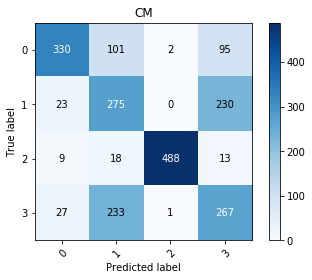

In [51]:
#plot confusion matrix
#get test index from train data with kfold
# get class name
classes = get_class_name(df_fix_path, target, target_label, chunksize=1000)
plot_cm(model, df_fix, classes.keys())

In [ ]:

def test(raw_file_test, bin_test_dir,
         num, size, fold, target='type_big'):
    make_data(raw_file_test, bin_test_dir)# make bin file
    target_label = '{}_label'.format(target)

    #test df
    df_test = pd.DataFrame({'file': os.listdir(bin_test_dir)})#make dataframe
    print('[*]Test {} samples'.format(len(df_test)))
    df_test_fix = add_col(df_test, bin_data_dir)  # fix dataframe
    df_test_fix = apply_scaler(df_test_fix, scaler=StandardScaler())  # apply scaler

    #get class labels from df _fix.csv
    df_fix_path = os.path.join(input_dir, 'data_fix.csv')
    classes = get_class_name(df_fix_path, target, target_label, chunksize=1000)

    #load model/weight
    model = CNN1D(filter_num=num,
                  filter_size=size,
                  dim=len(df_test_fix['data'][0]),
                  num_classes=len(classes))

    model_name = params['model_name_format'].format(num,
                                                    size,
                                                    fold)
    weight_path = os.path.join(model_dir, model_name)
    model.load_weights(weight_path)

    #get input
    X_test, X_test_byte, _ = get_train_data(df_test_fix,
                                             cnn_col='data',
                                             byte_cols=get_byte_cols(),
                                             target=None, 
                                             num_class=len(classes),
                                             index=None,
                                             test=True)
    y_pred = model.predict([X_test, X_test_byte]).argmax(axis=1)
    y_pred_label = [classes[pred] for pred in y_pred]
    df_test.loc[:, target] = y_pred_label
    return df_test


In [68]:
#test file
raw_file_test = os.path.join(input_dir, 'raw_data.raw') #raw file path
bin_test_dir = os.path.join(input_dir, 'test_bin') # save bin file path
df_test = test(raw_file_test, bin_test_dir,
               num=best_num, size=best_size, fold=best_fold)
df_test.head(20)


[*]Test 26400 samples
[*]Add col
[*]Apply Scaler


,file,type_big
0,18648,comp
1,3846,video
2,25963,comp
3,6722,video
4,21964,image
5,12565,comp
6,20362,enc
7,3804,image
8,16148,video
9,1788,image
